<a href="https://colab.research.google.com/github/nahumsa/VAE-RBM-Pretraining/blob/master/Pretraining%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pretraining-AutoEncoder-using-Restricted-Boltzmann-Machines" data-toc-modified-id="Pretraining-AutoEncoder-using-Restricted-Boltzmann-Machines-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pretraining AutoEncoder using Restricted Boltzmann Machines</a></span></li><li><span><a href="#Using-the-VAE-with-RBM-initialization" data-toc-modified-id="Using-the-VAE-with-RBM-initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using the VAE with RBM initialization</a></span></li></ul></div>

# Pretraining AutoEncoder using Restricted Boltzmann Machines

This code is based on this [repository](https://github.com/lane203j/deep-autoencoder-with-RBM-pretraining). But here we apply the RBM pretraining to the Beta-Variational autoencoder.

### Colab setup

In [1]:
!git clone https://github.com/nahumsa/VAE-RBM-Pretraining

Cloning into 'VAE-RBM-Pretraining'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 43 (delta 15), reused 33 (delta 11), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [2]:
% cd VAE-RBM-Pretraining/

/content/VAE-RBM-Pretraining


### Importing modules and data

In [0]:
try:
  %tensorflow_version 1.x

except Exception:
  pass  

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import np_utils
import seaborn as sns
import os

# Change figure aesthetics
%matplotlib inline
sns.set_context('paper', font_scale=1.2, rc={'lines.linewidth': 1.5})

#Removing warnings
def warn(*args, **kwargs):
    pass
    
import warnings
warnings.warn = warn

Using TensorFlow backend.


Importing the MNIST dataset

In [0]:
import tensorflow as tf
#Set Random Seed for reproduction
tf.compat.v1.set_random_seed(1234)

In [6]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32').reshape((60000,784)).T / 255.
x_test = x_test.astype('float32').reshape((10000,784)).T / 255.

threshold = 0.0705
x_train_bw = (x_train > threshold).astype(int)
x_test_bw = (x_test > threshold).astype(int)

11493376/11490434 [==============================] - 1s 0us/step


# Using the VAE with RBM initialization

In [0]:
# run params
SECTION = 'bvae_RBM'
RUN_ID = '0001'
DATA_NAME = 'D'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
%load_ext autoreload
%autoreload 2

In [9]:
from keras.models import Model
from Models.VAE import VariationalAutoencoder

#Parameters
layers = [784, 1000, 512, 256, 2]
epochs_pretraining = 5

#Defining the Beta-VAE
bvae = VariationalAutoencoder(layer_dims = layers)
bvae.pretrain(x_train_bw.T,epochs = epochs_pretraining, num_samples = 1000)
bvae.unroll()

Pretraining 

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training RBM layer 1, size: 784
Training RBM layer 2, size: 1000
Training RBM layer 3, size: 512












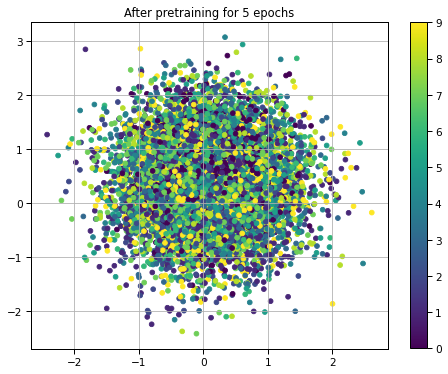

In [10]:
z_mu = bvae.encoder.predict(x_test.T)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_test)
plt.colorbar()
plt.title(f'After pretraining for {epochs_pretraining} epochs')
plt.grid()

In [11]:
bvae.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
encoder_dense_0 (Dense)         (None, 1000)         785000      encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_dense_1 (Dense)         (None, 512)          512512      encoder_dense_0[0][0]            
__________________________________________________________________________________________________
encoder_dense_2 (Dense)         (None, 256)          131328      encoder_dense_1[0][0]            
____________________________________________________________________________________________

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 5000
BETA = 10
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

In [0]:
# Training Parameters

BATCH_SIZE = 126

EPOCHS = 200

PRINT_EVERY_N_BATCHES = 100

INITIAL_EPOCH = 150

In [24]:
bvae.train(     
    x_train.T
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
          )

Epoch 151/200
60000/60000 [==============================] - 3s 55us/step - loss: 221.9401 - vae_r_loss: 167.9533 - vae_kl_loss: 5.3987
Epoch 152/200
60000/60000 [==============================] - 3s 53us/step - loss: 221.8938 - vae_r_loss: 167.9135 - vae_kl_loss: 5.3980
Epoch 153/200
60000/60000 [==============================] - 3s 52us/step - loss: 221.8173 - vae_r_loss: 167.7200 - vae_kl_loss: 5.4097
Epoch 154/200
60000/60000 [==============================] - 3s 50us/step - loss: 221.7655 - vae_r_loss: 167.7307 - vae_kl_loss: 5.4035
Epoch 155/200
60000/60000 [==============================] - 3s 53us/step - loss: 221.5900 - vae_r_loss: 167.6318 - vae_kl_loss: 5.3958
Epoch 156/200
60000/60000 [==============================] - 3s 53us/step - loss: 221.6840 - vae_r_loss: 167.4834 - vae_kl_loss: 5.4201
Epoch 157/200
60000/60000 [==============================] - 3s 50us/step - loss: 221.6350 - vae_r_loss: 167.3892 - vae_kl_loss: 5.4246
Epoch 158/200
60000/60000 [=====================

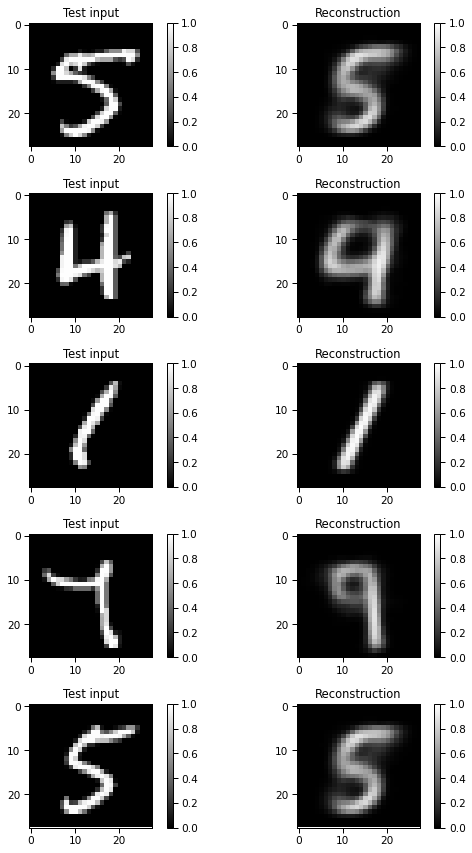

In [15]:
n_to_show = 5
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test.T[example_idx]

z_points = bvae.encoder.predict(example_images)

reconst_images = bvae.decoder.predict(z_points)

plt.figure(figsize=(8, 12))
for i in range(n_to_show):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(example_images[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconst_images[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

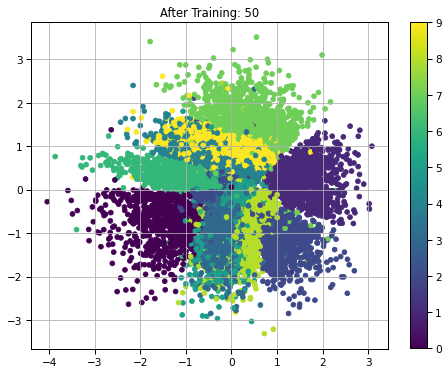

In [16]:
z_mu = bvae.encoder.predict(x_test.T)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_test)
plt.colorbar()
plt.title(f'After Training: {EPOCHS}')
plt.grid()

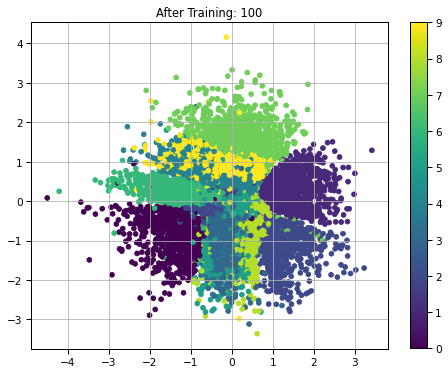

In [19]:
z_mu = bvae.encoder.predict(x_test.T)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_test)
plt.colorbar()
plt.title(f'After Training: {EPOCHS}')
plt.grid()

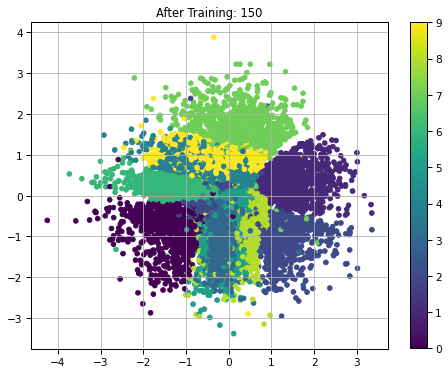

In [22]:
z_mu = bvae.encoder.predict(x_test.T)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_test)
plt.colorbar()
plt.title(f'After Training: {EPOCHS}')
plt.grid()

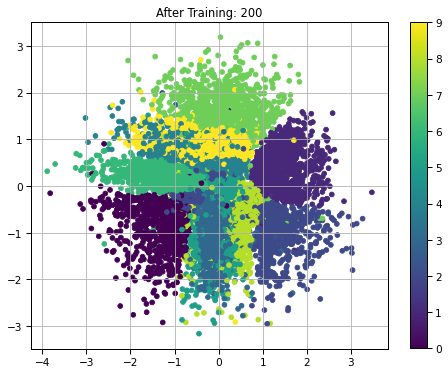

In [25]:
z_mu = bvae.encoder.predict(x_test.T)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_test)
plt.colorbar()
plt.title(f'After Training: {EPOCHS}')
plt.grid()

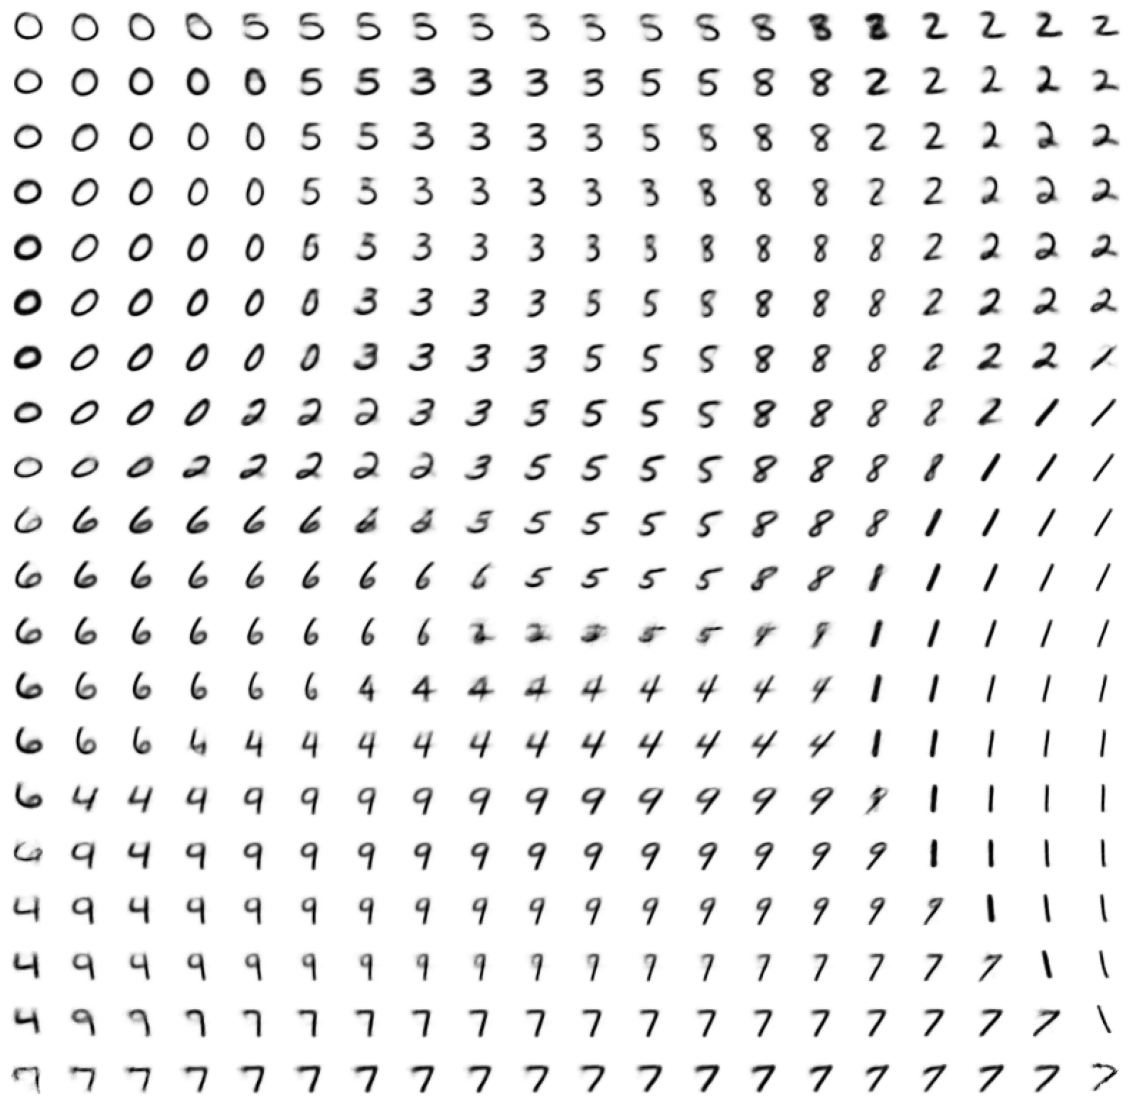

In [26]:
from scipy.stats import norm

grid_size = 20
figsize = 20

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = bvae.decoder.predict(z_grid)


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i].reshape((28,28)), cmap = 'Greys')